# Introducción a PyMC

Google Colab ya viene con una version de PyMC instalada. Pero queremos estar seguros que usamos la última versión disponible, que es la 5.16.2.


In [1]:
# El '%%capture' hace que no se muestren los mensajes. Pueden borrarlo.
# %%capture
# !pip install pymc==5.16.2

## Contenidos

* [¿Qué es PyMC?](#que-es-pymc)
* [¿Cómo usar PyMC?](#cómo-usar-pymc)
    * [Modelo](#modelo)
    * [InferenceData](#inferencedata)
    * [Análisis del _posterior_](#análisis-del-posterior)
    * [Resumen](#resumen)
* [InferneceData _cheatsheet_](#inferencedata-cheatsheet)
* [Ejercicios](#ejercicios)
* [Referencias](#referencias)

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import preliz as pz
import pymc as pm


print("ArviZ", az.__version__)
print("PyMC", pm.__version__)
print("PreliZ", pz.__version__)

ArviZ 0.19.0
PyMC 5.16.2
PreliZ 0.9.0


# ¿Qué es PyMC? <a class="anchor" id="que-es-pymc"></a>

Los lenguajes de programación probabilista permiten especificar modelos estadísticos bayesianos de una manera flexible utilizando código.

[PyMC](https://www.pymc.io/welcome.html) es un paquete de código abierto de Python que implementa un lenguaje de programación probabilista y provee los componentes fundamentales para la construcción de modelos bayesianos.

En PyMC se encuentran implementados métodos de inferencia de _Markov Chain Monte Carlo_ (MCMC) y algoritmos de inferencia variacional (ADVI). Uno de los algoritmos de MCMC implementados es el _No-U-Turn-Sampler_ (NUTS), una variante de _Hamiltonian Monte Carlo_ (HMC) que ajusta sus hiperparámetros automáticamente.

El algoritmo de muestreo NUTS funciona bien incluso en problemas donde se cuenta con un _posterior_ complejo (geométricamente) y en altas dimensiones. Esto permite que los usuarios puedan ajustar modelos de variada complejidad sin que sea necesario que cuenten con un conocimiento avanzado sobre el funcionamiento de los algoritmos de muestreo.

En la gran mayoría de los casos en que uno trabaja con PyMC lo hace escribiendo código en Python. Es más, gran parte del mismo PyMC está escrito en Python. Sin embargo, el "motor" que hace que PyMC funcione de la manera que lo hace es otro paquete llamado [PyTensor](https://pytensor.readthedocs.io/en/latest/).

PyTensor es un paquete de Python que permite definir, optimizar y evaluar expresiones matemáticas (avanzadas) que involucran arreglos multidimensionales de manera eficiente. PyTensor es una hija de [Theano](https://github.com/Theano/Theano) (librería para _deep learning_ antecesora a PyTorch, Tensorflow, etc.) desarrollada y mantenida por los desarrolladores de PyMC. Es frecuente que el uso avanzado de PyMC implique interacturar con componentes de PyTensor.

# ¿Cómo usar PyMC? <a class="anchor" id="como-usar-pymc"></a>

Para aprender a usar PyMC vamos a revisitar el problema que resolvimos en el primer día del taller.

> **Problema 1**
>
> Mookie Betts es un bateador que juega para Los Angeles Dodgers en la Major League Baseball (MLB) de los Estados Unidos.
>
> Este jugador se ha convertido en unas de las estrellas indiscutidas de la competencia al conseguir 45 _hits_ en sus primeros 115 turnos al bate en lo que va de la temporada regular del año 2024.
>
>Según los registros históricos, los bateadores de la MLB consiguen un _hit_ entre el 20% y 40% de las ocasiones que van al bate.
>
>A partir de los datos, ¿qué se puede concluir sobre la probabilidad de que Betts obtenga un  _hit_ al batear?
>
>Dado nuestro conocimiento previo y el desempeño de Betts en sus primeros 115 turnos al bate, ¿cuál es la probabilidad de que este jugador obtenga _hits_ en al menos el 40% de los casos al acumular 500 turnos al bate en la temporada?
>
>¿Qué supuesto(s) realizamos? ¿Cuál(es)?

El modelo que planteamos para dar respuesta al problema es

$$
\begin{aligned}
Y &\sim \text{Binomial}(N, \theta) \\
\theta &\sim \text{Beta}(\alpha, \beta)
\end{aligned}
$$

donde $Y$ es la cantidad de éxitos (_hits_) en $N$ ensayos (turnos al bateo) y $\theta$ es la probabilidad de que el bateador obtenga un _hit_.

Recordemos que habíamos utilizado un _prior_ uniforme para $\theta$ con $\alpha=1$ y $\beta=1$.

## Modelo

Una de las bondades de PyMC es que la sintaxis para especificar modelos es intuitiva y se parece a la misma que utilizamos para escribir modelos probabilísticos en un texto.

Antes de describir la sintaxis, definamos el modelo en PyMC y luego analicemos el código escrito línea por línea.

In [3]:
# Cantidad de ensayos y éxitos
N = 145
y = 45

# Modelo
with pm.Model() as model:                       # (1)
    theta = pm.Beta("theta", alpha=1, beta=1)   # (2)
    pm.Binomial("y", p=theta, n=N, observed=y)  # (3)

Eso es todo, ya tenemos nuestro modelo de PyMC en una variable de Python llamada `modelo`. En tan solo tres líneas de código reproducimos el modelo escrito anteriormente en el texto con distribuciones de probabilidad. Ahora, hagamos de lo que acabamos de escribir.

**Primera línea**

En esta primera línea de código suceden tres cosas (!).

* Se utiliza un _context manager_, que reconocemos por la sentencia `with` (más sobre _context managers_ [acá](https://ellibrodepython.com/context-managers-python)).
* Se inicializa un modelo con `pm.Model()`.
* Se guarda el modelo inicializado en la variable `model`.

El uso del _context manager_ para crear modelos en PyMC no es obligatorio, pero sí es fuertemente recomendado. Esto nos posibilita escribir distribuciones como en las líneas 2 y 3 y que estas sean automáticamente añadidas al modelo.

**Segunda línea**

Inicializamos una variable aleatoria que sigue una distribución beta de parámetros $\alpha = 1$ y $\beta=1$.

* Las distribuciones de probabilidad están disponibles directamente en el módulo `pm` y se escriben con la primera letra en mayúscula. Por ejemplo: `pm.Beta`, `pm.Binomial`, `pm.Normal`, `pm.Gamma`, etc. Más adelante veremos que la regla general es usar **CamelCase**. Así, una distribución media normal se escribe `pm.HalfNormal` o una gamma inversa es `pm.InverseGamma`.
* Es necesario asignarle un nombre a las variables al momento de crear la distribución. El nombre es el primer argumento y  en este caso usamos `"theta"`. Este nombre es el nombre con el que PyMC va a reconocer a la variable y es independiente del nombre con el que guardamos al objeto creado en Python. Sin embargo, es recomendable utilizar el mismo en ambos casos.

**Tercera línea**

Inicializamos una variable aleatoria que sigue una distribución binomial y le llamamos `"y"`. 

* La parametrización de la distribución (i.e. los nombres que usa PyMC para los parámetros de una distribución) no tienen por que ser los que usamos diariamente. La [binomial](https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.Binomial.html) se crea con `p` y `n`, que se corresponden con $\theta$ y $N$ en nuestro modelo. Para ver las parametrizaciones disponibles de todas las distribuciones se puede consultar la [documentación](https://www.pymc.io/projects/docs/en/stable/api/distributions.html).
* El uso del argumento `observed`. Indica que la cantidad descrita por la variable aleatoria es observada (y se pasan los valores observados). Es lo que convierte a la binomial en la verosimilitud (o el modelo observacional) de nuestro modelo bayesiano.

Ok, tenemos el modelo, ¿ahora qué?

Un posible primer paso es observar una representación del modelo que sirve para verificar que el modelo tiene los componentes que quisimos incorporar. Simplemente "mostramos" el modelo con `display()`, que es una función automáticamente cargada en Jupyter _notebooks_. Al hacerlo se obtiene una representación de las distribuciones renderizada con [KateX](https://katex.org/).

In [4]:
display(model)

theta ~ Beta(1, 1)
    y ~ Binomial(145, theta)

Y si usamos el método `.to_graphviz()` se obtiene un grafo hecho con la librería [graphviz](https://graphviz.readthedocs.io/en/stable/manual.html).

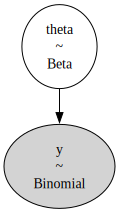

In [5]:
model.to_graphviz()

Podemos ver que en nuestro modelo se encuentran 2 variables aleatorias, `theta` e `y`, que `y` depende de `theta` y es además observada (por eso está coloreada en gris) y cuales son sus distribuciones de probabilidad. Desafortunadamente, lo que no podemos ver es cómo es que `y` depende de `theta`.

Si bien visualizar el grafo puede ser útil, lo que inevitablemente queremos hacer es actualizar la información previa a la luz de los datos. Dicho de otra manera, queremos encontrar el _posterior_.

Como mencionamos anteriormente, PyMC utiliza algoritmos de MCMC para obtener muestras del _posterior_ -- no encuentra un _posterior_ de manera analítica, ni devuelve una expresión matemática. **PyMC muestrea el _posterior_**. ¿Cómo? Simplemente con la función `pm.sample()`.

Lo único que tenemos que tener en cuenta es que nuevamente hay que usar el _context manager_ para indicar el modelo para el cual vamos a muestrear el _posterior_.

In [6]:
with model:
    # Pasamos `random_seed` para que el resultado sea reproducible
    idata = pm.sample(random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


## InferenceData

En los mensajes debajo de la celda vemos que PyMC obtuvo muestras utilizando 2 cadenas (`chain 0` y `chain 1`). Exploremos el objeto generado...



In [7]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

¡¿Qué es esto y donde están mis muestras?!

Bueno, paso a paso.

`idata` es un `InferenceData` de [ArviZ](https://python.arviz.org/en/stable/), la librería para el análisis exploratorio de modelos bayesianos. Es su documentación tiene [una introducción que explica qué es `InferenceData`](https://python.arviz.org/en/stable/getting_started/XarrayforArviZ.html). En esta sección describimos brevemente qué es un objeto `InferenceData` y a lo largo de la _notebook_ iremos mostrando cómo trabajar con él (y los objetos que contiene).

Un objeto `InferenceData` es simplemente un **contenedor** de grupos de datos relevantes para el modelado bayesiano. Cada uno de esos grupos tiene un nombre. En nuestro `idata` podemos observar 3 grupos:

* `posterior`: Muestras del _posterior_. Es el que analizaremos más en detalle.
* `sample_stats`: Métricas que sirven para diagnosticar el _sampler_ utilizado y las cadenas.
* `observed_data`: Los valores que se pasaron como `observed` en el modelo.

Miremos en detalle lo que contiene el grupo `posterior`.

In [8]:
idata["posterior"]

<xarray.Dataset> Size: 40kB
Dimensions:  (chain: 4, draw: 1000)
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    theta    (chain, draw) float64 32kB 0.2881 0.3142 0.3162 ... 0.2854 0.2636
Attributes:
    created_at:                 2024-09-02T13:42:32.218007+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.2
    sampling_time:              1.8921692371368408
    tuning_steps:               1000

Ahora vemos que en la parte superior izquierda de la salida en vez de decir `arviz.InferenceData` dice `xarray.Dataset`. Esto es porque los objetos que contiene un `InferenceData` son `Dataset`s de [xarray](https://docs.xarray.dev/en/stable/), la librería sobre la cual estan construidas las estructuras de datos de ArviZ.

Los `Dataset`s de xarray son objetos bastante complejos. Para el uso que le damos nosotros, alcanza con pensarlos como **contenedores de arreglos multidimensionales**. Estos arreglos multidimensionales tienen nombres y son los que vemos debajo de `Data variables`. En nuestro caso, hay una sola variable que se llama `theta`. Veamos que tiene:

In [9]:
idata["posterior"]["theta"]

<xarray.DataArray 'theta' (chain: 4, draw: 1000)> Size: 32kB
array([[0.28813046, 0.31420434, 0.31616752, ..., 0.32529346, 0.32529346,
        0.32087122],
       [0.36563278, 0.33319138, 0.29892138, ..., 0.39208093, 0.3521378 ,
        0.3791212 ],
       [0.29509054, 0.25570613, 0.33339009, ..., 0.27917395, 0.33899134,
        0.33318418],
       [0.30880492, 0.30474047, 0.29026277, ..., 0.28544057, 0.28544057,
        0.26356811]])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999

Finalmente, este otro objeto, es también otro tipo de objeto: un `DataArray` de xarray (nuevamente, ver parte superior izquierda de la salida).

Un `DataArray` de xarray es similar a un `array` de NumPy. La diferencia principal es que en vez de tener ejes numerados del `0` a `n-1`, tiene dimensiones (ejes) nombradas. En este caso, las dimensiones son **`chain`** y **`draw`**. La primer dimensión tiene longitud 2, porque se usaron 2 cadenas, y la segunda tiene longitud 1000, porque se obtuvieron 1000 muestras en cada cadena.

El siguiente esquema resume a los objetos `InferenceData`:

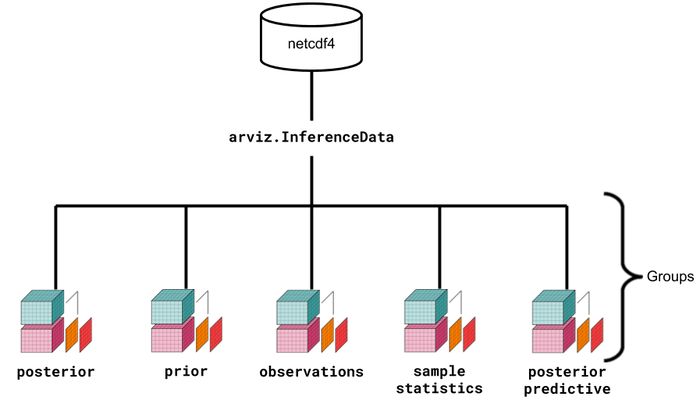

Pasando en limpio:

1. `idata` es un `InferenceData`, colección de grupos. Cada grupo es un `Dataset`.
2. `posterior` es un `Dataset`, una colección de variables. Cada variable es un `DataArray`. 
3. Los `DataArray`s son como _arrays_ de NumPy. Estos no tienen necesariamente las mismas dimensiones. Ver que las representaciones en cyan, magenta, naranja y rojo en la figura no tienen la misma dimensionalidad.
4. `theta` es un `DataArray` que contiene las muestras del _posterior_. **Estas son las muestras que analizamos**.

## Análisis del _posterior_ <a class="anchor" id="analisis-posterior"></a>

### Diagnósticos

Toda inferencia se realiza a partir de las muestras del _posterior_ mediante el cálculo de algún resumen utilizando Monte Carlo.

Con PyMC no utilizamos métodos que extraen muestras independientes del _posterior_ de manera exacta. Usamos métodos de Markov Chain Monte-Carlo (MCMC) que ni generan muestras independientes ni estas provienen del _posterior_ directamente. Sin embargo, las muestras obtenidas mediante MCMC representarán al _posterior_ fielmente y permitirán extraer conclusiones válidas cuando la cantidad de muestras sea lo suficientemente grande.

¿Cómo determinamos si la cantidad de muestras del _posterior_ es lo suficientemente grande? No existe una única prueba que nos permita concluir con total certeza que las muestras obtenidas representan fielmente al _posterior_. Pero sí existen gráficos y resúmenes numéricos que ayudan a determinar si las cadenas de MCMC están "sanas" y nos habilitan a usar las muestras para extraer conclusiones. Buscamos que nuestra cadena:

* Explore "todo" el dominio de la distribución _a posteriori_ (en realidad, la región del dominio donde se concentra la probabilidad).
* Sea insensible a las condiciones iniciales, comportádose de similar manera aún cuando arranca de diferentes puntos inciales.
* Sea eficiente, presentando una baja o casi nula dependencia entre los valores de las muestras (autocorrelación).

#### _Traceplot_

Un gráfico de diagnóstico muy frecuentemente utilizado es el _traceplot_. Podemos pensarlo como una serie de tiempo que muestra los valores generados por la cadena en cada paso de la simulación. En ArviZ esto se genera con `plot_trace()` y lo único que tenemos que hacer es pasarle el `InferenceData` obtenido con `pm.sample()`.

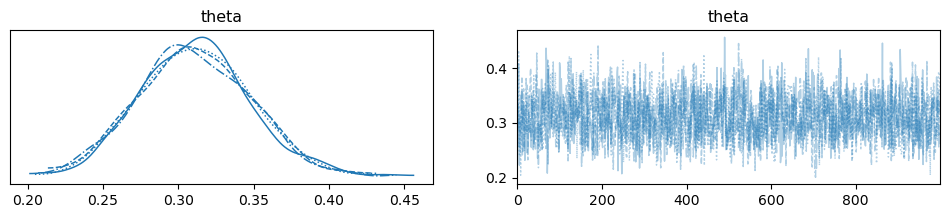

In [10]:
az.plot_trace(idata);

El _traceplot_ es el gráfico en el panel de la derecha. Buscamos que las trayectorias sean los más parecidas a un ruido blanco, recorriendo un rango similar en el eje vertical (el espacio del parámetro) y sean en consecuencia prácticamente imposibles de distinguir unas de otras. 

Que la trayectoria se parezca a un ruido blanco nos señala dos aspectos deseables:

* Que la autocorrelación (dependencia) entre las muestras es baja y por lo tanto el algoritmo es eficiente.
* Que el algoritmo es estable, recorriendo la misma región del espacio paramétrico.

Además, que las cadenas sean indistinguibles, nos habla de que el algoritmo es insensible a las condiciones inciales (ya que cada cadena empieza de un punto dinstinto).

En el panel de la izquierda tenemos una estimación de la función de densidad _a posteriori_ para las muestas con cada cadena. Buscamos que estas densidades sean parecidas, indicando que con cada cadena obtenemos una estimación similar del _posterior_.

No hay de que preocuparse en nuestro problema. El _traceplot_ se asemeja bastante a un ruido blanco, sin tendencias, estancamientos o alta dependencia entre muestras

#### Gráfico de autocorrelación

Si bien uno puede tener alguna noción de la autocorrelación a partir del _traceplot_, es posible usar un diagnóstico más específico para diagnosticar autocorrelación: la función de autocorrelación. Esta se obtiene con `plot_autocorr()` de ArviZ que grafica la función de autocorrelación para cada parámetro y cadena.

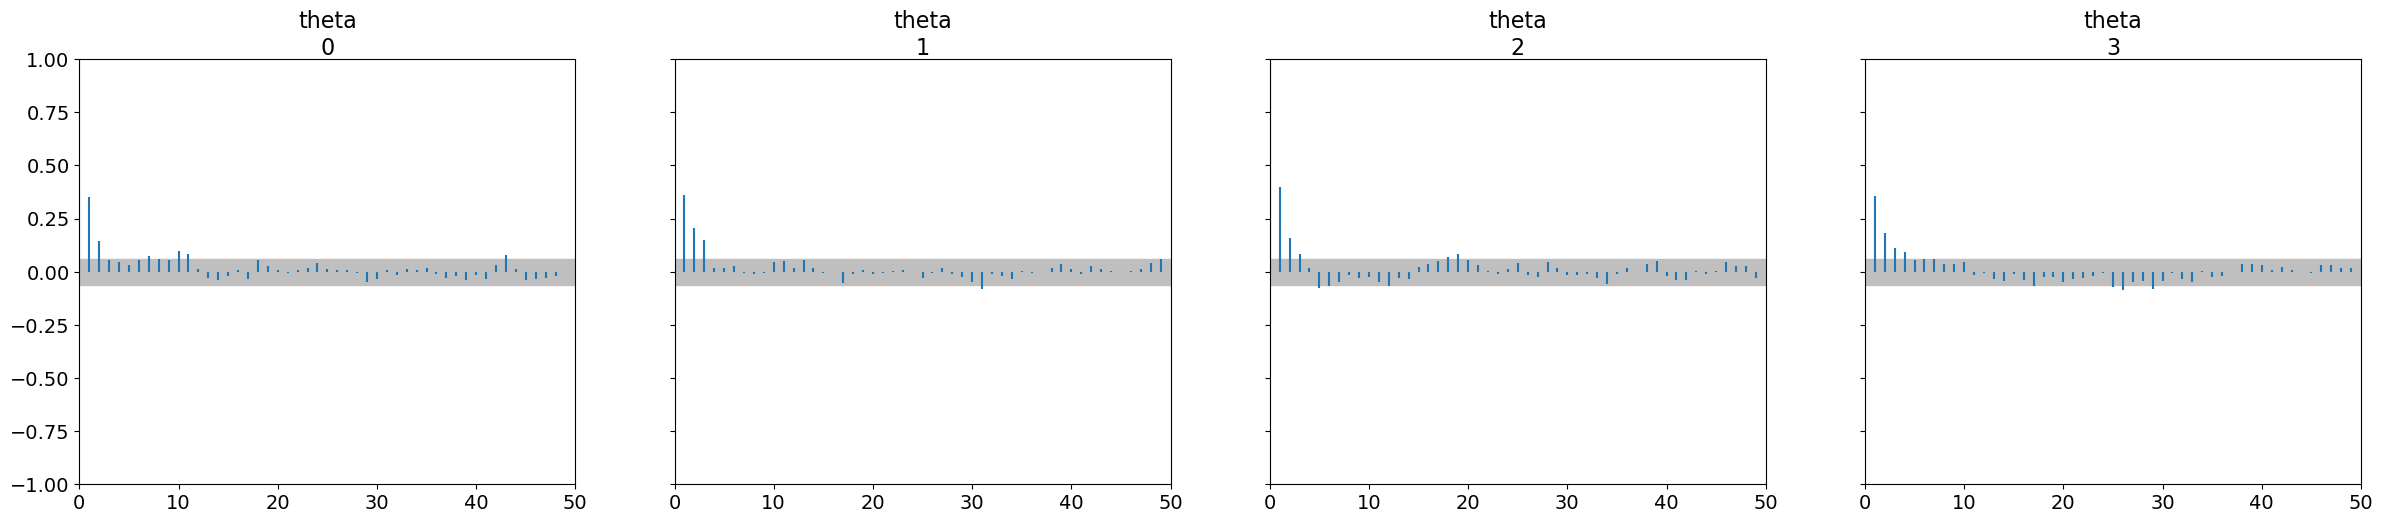

In [11]:
az.plot_autocorr(idata, max_lag=50);

La altura del primer bastón es mayor a 0.4, indicando un grado de autocorrelación no despreciable entre cada muestra y la inmediata muestra anterior. Pero esto no significa que tengamos un problema grave de autocorrelación (lo hubieramos notado en el _traceplot_). Además, dado que la altura de la función para otros rezagos es muy baja, podemos concluir que la autocorrelación entre muestas disminuye muy rápidamente.

#### Estadística $\hat{R}$

El estadístico $\hat{R}$ es un indicador de convergencia que se utiliza en conjunto con el _traceplot_ para evaluar la convergencia y mezcla de las cadenas. 
No solo deseamos que las cadenas sean estables de manera individual, también deseamos que las cadenas sean consistentes y que todas obtengan muestras representativas del _posterior_. 

El principio detrás de este resumen numérico es que si el muestreo es representativo del _posterior_, la diferencia promedio entre cadenas debe ser similar a la diferencia promedio en la cadena. Por ello, requiere de múltiples cadenas para su cómputo.

Un valor de $\hat{R}$ cercano a 1 indica convergencia y buena mezcla. Valores iguales o mayores a 1.01 nos hacen cuestionar la convergencia y mezcla de las cadenas.

Su cómputo en ArviZ es muy sencillo, solo hay que usar la funcion `az.rhat()`.

In [12]:
az.rhat(idata)

<xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    theta    float64 8B 1.001

Podemos ver $\hat{R}$ para $\theta$ prácticamente 1, indicando convergencia y mezcla de las cadenas.

**Nota** Es mejor utilizar 4 o más cadenas para calcular este diagnóstico. Más adelante veremos como especificar la cantidad de cadenas a muestrear.

#### Tamaño de muestra efectivo

Cuando utilizamos un algoritmo de Markov-Chain Monte-Carlo para obtener muestras de una distribución cualquiera, tenemos que evaluar la correlación entre las muestras. Una de las bondades del algoritmo NUTS que utiliza PyMC es que resulta en muestras que en general tienen un bajo nivel de autocorrelación, comparado a otros métodos como Metropolis-Hastings. Pero eso no significa que la autocorrelación sea nula (como ya vimos).

Que un conjunto de muestras esté correlacionado significa que la cantidad de información que contiene es menor que el de un conjunto de muestras independientes de igual tamaño. Es decir, 1000 muestras correlacionadas contienen menos información que 1000 muestras independientes.

Existen estimadores del tamaño efectivo de muestra y ArviZ implementa uno de ellos. Para obtener la estimación para cada parámetro del modelo, usamos `az.ess()`, donde ESS es la sigla de _Effective Sample Size_.

In [13]:
az.ess(idata)

<xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    theta    float64 8B 1.563e+03

El tamaño de muestra efectivo es prácticamente 730 (en base a 2000 muestras obtenidas por MCMC). Es decir, la cantidad de muestras que obtuvimos "equivalen" a 730 muestras independientes en cuanto al error introducido por aproximar los resultados con Monte Carlo. Esto es más que suficiente para estimar medias, varianzas e intervalos de credibilidad.

#### Resumen

Finalmente, otra función que se suele utilizar mucho al trabajar con ArviZ es `az.summary()`. La razón es muy simple, con una llamada a una sola función obtenemos una gran variedad de estadística resumen que son de interés.

In [14]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.311,0.037,0.241,0.381,0.001,0.001,1563.0,2393.0,1.0


Tenemos:

* La media _a posteriori_ de $\theta$ (`mean`)
* El desvío estándar _a posteriori_ de $\theta$ (`sd`)
* Un _Highest Density Interval_ (HDI) del 94% para $\theta$ (`hdi_3%` es el límite inferior y `hdi_97%` es el límite superior)
* Estimaciones de la media y el desvío para el _Monte Carlo Standard Error_ (`mcse_mean` y `mcse_sd`). 
* Tamaños efectivos para el centro y las colas de la distribución (`ess_bulk` y `ess_tail`)
* Estimación del $\hat{R}$.

### Inferencias

Llegó la hora de empezar a extraer conclusiones para la cantidad de interés (la probabilidad de obtener un _hit_) a partir de las muestras del _posterior_.

Por ejemplo, para calcular la media _a posteriori_ de $\theta$ uno puede utilizar el método `.mean()`.

In [15]:
idata["posterior"]["theta"].mean()

<xarray.DataArray 'theta' ()> Size: 8B
array(0.311171)

Y para obtener un intervalo de credibilidad del 90%, podemos usar el método `.quantile()` e indicar los cuantiles que se corresponden con los bordes del intervalo.

In [16]:
idata["posterior"]["theta"].quantile((0.05, 0.95))

<xarray.DataArray 'theta' (quantile: 2)> Size: 16B
array([0.25115804, 0.37361842])
Coordinates:
  * quantile  (quantile) float64 16B 0.05 0.95

El objeto que nos devuelve es un `xarray.DataArray`. Siempre podemos convertirlo a un _array_ de NumPy con el método `.to_numpy()`.

In [17]:
idata["posterior"]["theta"].quantile((0.05, 0.95)).to_numpy()

array([0.25115804, 0.37361842])

Otra función muy conveniente en ArviZ es `plot_posterior()`. Si le pasamos solo el `InferenceData`, va a intentar graficar la densidad marginal para cada variable que se encuentre en `idata.posterior`. También podemos especificar de antemano cuál es la variable que queremos visualizar, como hacemos acá.

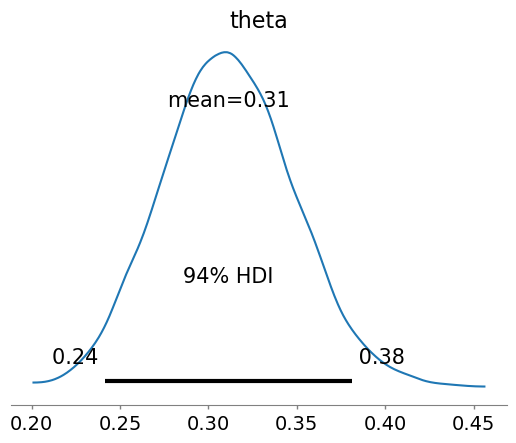

In [18]:
az.plot_posterior(idata, var_names="theta");

Otra opción, que prescinde de ArviZ, es convertir las muestras a un `array` de NumPy y trabajar directamente con ellas. En general esto no es recomendable porque se pierden metadatos relacionados a las muestras. Pero también hay situaciones donde trabajar con xarray resulta complicado y es bueno saber que uno siempre puede volver al clásico NumPy.

In [19]:
theta_posterior = idata["posterior"]["theta"].to_numpy()
print(theta_posterior.shape) # 2 cadenas, 1000 muestras por cadena
theta_posterior

(4, 1000)


array([[0.28813046, 0.31420434, 0.31616752, ..., 0.32529346, 0.32529346,
        0.32087122],
       [0.36563278, 0.33319138, 0.29892138, ..., 0.39208093, 0.3521378 ,
        0.3791212 ],
       [0.29509054, 0.25570613, 0.33339009, ..., 0.27917395, 0.33899134,
        0.33318418],
       [0.30880492, 0.30474047, 0.29026277, ..., 0.28544057, 0.28544057,
        0.26356811]])

In [20]:
# Media a posteriori
np.mean(theta_posterior)

0.3111710021465552

In [21]:
# Intervalo de credibilidad a posteriori
np.quantile(theta_posterior, (0.05, 0.95))

array([0.25115804, 0.37361842])

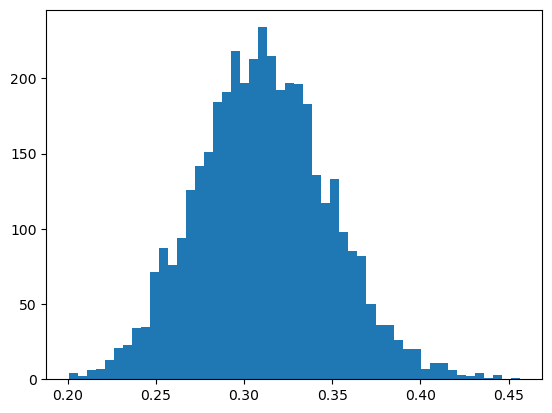

In [22]:
# Posterior marginal
plt.hist(theta_posterior.flatten(), bins=50);

#### Distribución predictiva _a posteriori_

Recordemos la segunda pregunta de nuestro problema

> Dado nuestro conocimiento previo y el desempeño de Betts en sus primeros 115 turnos al bate, ¿cuál es la probabilidad de que este jugador obtenga _hits_ en al menos el 40% de los casos al acumular 500 turnos al bate en la temporada?

Que la traducimos en

$$
P(\tilde{Y} \ge 200 \mid Y = y, N = 500)
$$

y se calcula utilizando la distribución predictiva _a posteriori_.

El enfoque de PyMC es trabajar con muestras del _posterior_ y en consecuencia también vamos a trabajar con muestras de la distribución predictiva _a posteriori_.

Independientemente del modelo que hayamos construido, siempre vamos a utilizar la misma interface para obtener muestras del _posterior_, `pm.sample()`. La misma idea aplica para la obtención de muestras de la distribución predictiva _a posteriori_. La función en cuestión es `pm.sample_posterior_predictive()`.

A diferencia de `pm.sample()`, es necesario pasarle un `InferenceData` a `pm.sample_posterior_predictive()`. A partir del modelo y la muestras contenidas en el `InferenceData`, PyMC sabe como obtener muestras predictivas.

In [23]:
with model:
    # idata.extend() hace que se agregue un grupo nuevo al existente InferenceData
    idata.extend(pm.sample_posterior_predictive(idata))

Sampling: [y]


Output()

Ahora, vemos que nuestro `idata` tiene un nuevo grupo, `posterior_predictive`.

In [24]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [25]:
idata.posterior_predictive

<xarray.Dataset> Size: 40kB
Dimensions:  (chain: 4, draw: 1000)
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (chain, draw) int64 32kB 45 45 49 59 45 30 34 ... 55 49 40 40 38 40
Attributes:
    created_at:                 2024-09-02T13:42:37.017024+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.2

Este grupo tiene una variable llamada `y` porque es el nombre con el que llamamos a la variable observada en nuestro modelo de PyMC. Por cada muestra del posterior, tenemos generado un valor de `y`.

Una forma rápida de visualizar la distribución predictiva (o cualquier distribución en base a muestras) es con `plot_dist()` de ArviZ.

<Axes: >

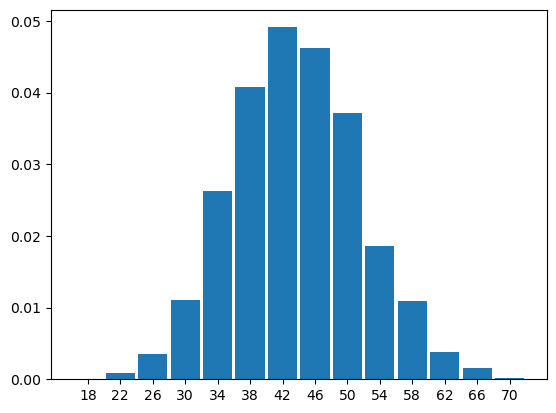

In [26]:
az.plot_dist(idata["posterior_predictive"]["y"])

ArviZ reconoce de manera correcta que se trata de una variable discreta y por lo tanto no estima una función de densidad. Sin embargo, lo que sí podemos notar es que ArviZ agrupó valores en _bins_. 

Construyamos el gráfico a mano, con una barra para cada valor de `y`.

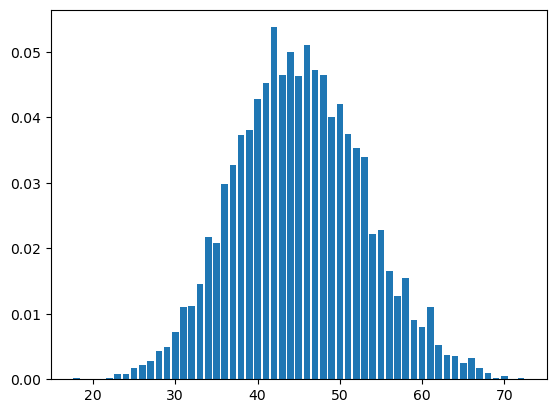

In [27]:
# Obtener los valores como un array unidimensional de numpy 
y_rvs = idata.posterior_predictive.y.to_numpy().flatten()

values, counts = np.unique(y_rvs, return_counts=True)

plt.bar(values, counts / counts.sum());

La forma de la distribución es similar, solo que ahora se obtiene una mayor granularidad. 

Los valores más probables para la cantidad de _hits_ que se esperan obtener está entre 20 y 70.

Sin embargo, esta tenemos que notar que esta no es la distribución predictiva que buscamos. Esta es la distribución predictiva _a posteriori_ cuando $N=115$. Nosotros necesitamos la distribución predictiva _a posteriori_ cuando $N=385$, ¿cómo lo cambiamos? De alguna forma, tenemos que hacer que $N$ deje de ser $N=115$ y pase a ser $N=385$.

PyMC nos permite cambiar valores de variables que intervienen en el modelo siempre y cuando las hayamos registrado explícitamente en el modelo. Para eso usamos [_data containers_](https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.Data.html#pymc.Data) que se crean con `pm.Data`.

Una similitud entre los contenedores de datos y las distribuciones es que los primeros también necesitan de un nombre explícito que se pasa como primer argumento.

In [28]:
N = 115
y = 45

with pm.Model() as model:
    # Le "pedimos" al modelo que registre una variable, conocida, que se llama N
    # y cuyo valor es el de la variable `N` de Python.
    N_data = pm.Data("N", N).astype(int) # Necesitamos la conversión explícita a 'int'
    theta = pm.Beta("theta", alpha=1, beta=1)
    pm.Binomial("y", p=theta, n=N_data, observed=y)
    idata = pm.sample(random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


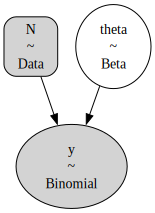

In [29]:
model.to_graphviz()

En el grafo generado vemos que hay una nueva variable, `N`. Está coloreada en gris porque es una variable cuyo valor es conocido. Pero a diferencia de `y` no es una elipse, que se usa para verosimilitudes. Es un cuadrado con sus bordes redondeados y esto representa que es una constante, no depende de cantidades desconocidas ni tiene una distribución.

Una vez hecha la inferencia, es decir, obtenidas las muestras del _posterior_, es posible asignarle un nuevo valor a `N`.

En este caso, fijamos $N = 385$ y obtenemos muestras de la distribución predictiva _a posteriori_ generadas a partir de las muestras del posterior de $\theta$ disponibles en `idata` y el valor de $N$ que acabamos de asignar.

Para "fijar" o reemplazar valores constantes existentes por valores constantes nuevos, se usa `pm.set_data()` y le pasamos un diccionario donde las claves son los nombres de las variables y los valores los valores a fijar.

In [30]:
with model:
    # Fijar un nuevo valor de N
    pm.set_data({"N": 385})
    
    # Obtener muestras de la distribución predictiva a posteriori
    # y guardar los valores en el `idata` que ya tenemos
    idata.extend(pm.sample_posterior_predictive(idata))

Sampling: [y]


Output()

Es posible visualizar la distribución predictiva _a posteriori_ a partir de las muestras en el grupo `posterior_predictive`.

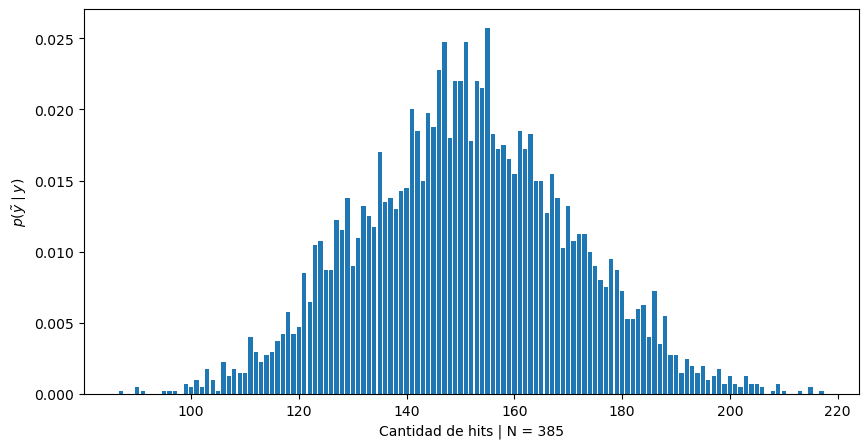

In [31]:
fig, ax = plt.subplots(figsize=(10, 5))

y_rvs = idata.posterior_predictive.y.to_numpy().flatten()
values, counts = np.unique(y_rvs, return_counts=True)
ax.bar(values, counts / counts.sum())
ax.set(xlabel="Cantidad de hits | N = 385", ylabel="$p(\\tilde{y} \mid y)$");

Para responder la pregunta planteada, hay que calcular $P(\tilde{Y} \ge 155 \mid y)$. Esto equivale a la siguiente sumatoria (por tratarse de una variable discreta):

$$
P(\tilde{Y} \ge 155) = \sum_{\tilde{y} = 155}^{385} p(\tilde{y} \mid  y)
$$

De manera visual, la probabilidad de interés equivale a sumar las alturas de las barras pintadas de color naranja en el siguiente gráfico.

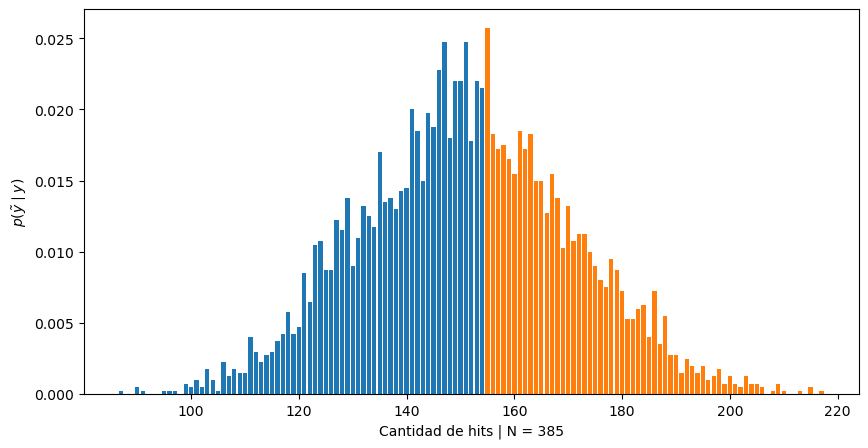

In [32]:
fig, ax = plt.subplots(figsize=(10, 5))

y_rvs = idata.posterior_predictive.y.to_numpy().flatten()
values, counts = np.unique(y_rvs, return_counts=True)

color = ["C0" if value < 155 else "C1" for value in values]

ax.bar(values, counts / counts.sum(), color=color)
ax.set(xlabel="Cantidad de hits | N = 385", ylabel="$p(\\tilde{y} \mid y)$");

Y usando Monte Carlo, equivale a calcular la propoción de muestras de la distribución predictiva _a posteriori_ que son mayores o iguales a 155.

In [33]:
(y_rvs >= 155).mean()

0.42425

## Resumen <a class="anchor" id="resumen"></a>

En esta breve sección se resumen los pasos que realizamos para crear nuestro modelo en PyMC, obtener muestras del _posterior_, evaluar los diagnósticos del _sampler_, y dar respuesta a las preguntas planteadas a través de las muestras de la distribución _a posteriori_ y de la predictiva _a posteriori_.

In [34]:
N = 115
y = 45

# Inicializar modelo
with pm.Model() as model:

    # Registrar 'N' como una variable del modelo conocida
    N_data = pm.Data("N", N).astype(int)

    # Distribución a priori para la probabilidad de éxito
    theta = pm.Beta("theta", alpha=1, beta=1)

    # Distribución para la variable respuesta (i.e. modelo observacional)
    pm.Binomial("y", p=theta, n=N_data, observed=y)

    # Obtener muestras del posterior
    # chains: cantidad de cadenas
    # draws: cantidad de muestras por cadena
    # random_seed: semilla para la determinación de los valores iniciales y
    #              por lo tanto de todas las muestras obtenidas con NUTS
    idata = pm.sample(chains=4, draws=1000, random_seed=121195)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


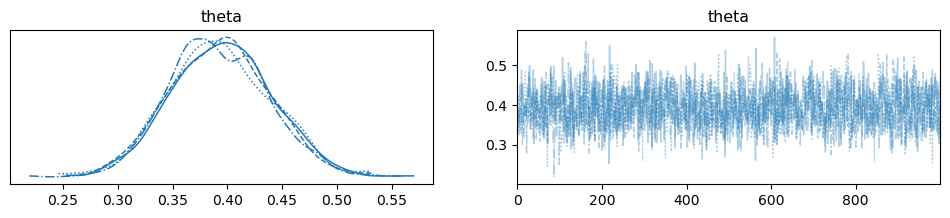

In [35]:
az.plot_trace(idata);

In [36]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.393,0.046,0.315,0.483,0.001,0.001,1729.0,2488.0,1.0


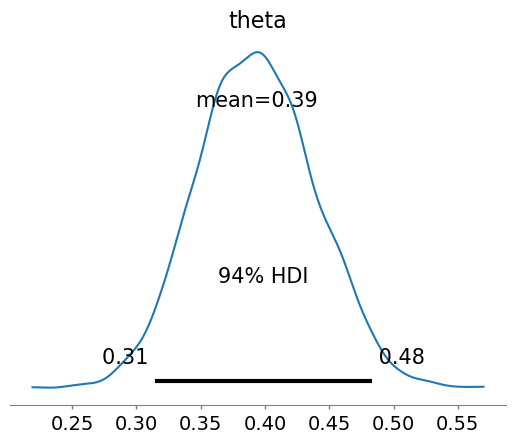

In [37]:
az.plot_posterior(idata);

In [38]:
with model:
    pm.set_data({"N": 385})
    idata.extend(pm.sample_posterior_predictive(idata))

Sampling: [y]


Output()

In [39]:
(idata.posterior_predictive["y"] > 155).mean().item()

0.4155

# `InferenceData` _cheatsheet_ <a class="anchor" id="cheatsheet"></a>

Los dos conceptos principales que debemos comprender al usar objetos `InferenceData` son las **dimensiones** (`dims`) y las **coordenadas** (`coords`).

Las **dimensiones** de un objeto se refieren a los ejes, que tienen asignados nombres específicos. Por ejemplo, una parámetro escalar tendrá dimensiones `(chain, draw)` y una variable que es un vector tendrá dimensiones `(chain, draw, var_dim_0)`. Las dimensiones `chain` y `draw` van a estar siempre presentes y luego es posible que se añadan dimensiones correspondientes a los parámetros del modelo. Es importante que cada dimensión de una variable en un `InferenceData` tenga un nombre que coincida con el nombre de coordenada.

Una **coordenada** es un _array_ que tiene un nombre y etiqueta una dimensión. Por ejemplo, la coordenada `chain`, que siempre estará presente, tendrá los valores `[0, 1, 2, 3]` si se corrieron 4 cadenas. Esta coordenada corresponde a la dimensión `chain` que mencionamos antes. En resumen, los nombres de las coordenadas funcionan como etiquetas, y sus valores como las marcas correspondientes a lo largo de una dimensión.

Si, ya lo sé, los dos párrafos anteriores resultan bastante confusos. Por eso mismo, acá debajo dejamos algunos ejemplos que muestran como realizar algunas tareas con un objeto `InferenceData`. Y además, todavía tenemos dos notebooks donde vamos a continuar utilizando esta estructura de datos.

Usamos un `InferenceData` generado a partir de un modelo construido para el análisis de equipos de rugby en el contexto del campeonato conocido como Six Nations. En ArviZ, la descripción de este `InferenceData` dice:

> The Six Nations Championship is a yearly rugby competition between Italy, Ireland, Scotland, England, France and Wales. Fifteen games are played each year, representing all combinations of the six teams.
>
> This example uses and includes results from 2014 - 2017, comprising 60 total games. It models latent parameters for each team's attack and defense, as well as a global parameter for home team advantage.
>
> See https://github.com/arviz-devs/arviz_example_data/blob/main/code/rugby/rugby.ipynb for the whole model specification.

In [40]:
idata_rugby = az.load_arviz_data("rugby")
idata_rugby

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> log_prior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> unconstrained_posterior

De arranque ya vemos que la un `InferenceData` puede contener una gran variedad de grupos. Pero eso no es el objeto de esta sección. Vamos a lo nuestro.

¿Cómo acceder un grupo?

In [41]:
idata_rugby.posterior

<xarray.Dataset> Size: 452kB
Dimensions:    (chain: 4, draw: 500, team: 6)
Coordinates:
  * chain      (chain) int64 32B 0 1 2 3
  * draw       (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * team       (team) <U8 192B 'Wales' 'France' 'Ireland' ... 'Italy' 'England'
Data variables:
    home       (chain, draw) float64 16kB ...
    intercept  (chain, draw) float64 16kB ...
    atts_star  (chain, draw, team) float64 96kB ...
    defs_star  (chain, draw, team) float64 96kB ...
    sd_att     (chain, draw) float64 16kB ...
    sd_def     (chain, draw) float64 16kB ...
    atts       (chain, draw, team) float64 96kB ...
    defs       (chain, draw, team) float64 96kB ...
Attributes:
    created_at:                 2024-03-06T20:46:23.841916
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.10.4+7.g34d2a5d9
    sampling_time:              8.503105401992798
    tuning_steps:               1000

In [42]:
idata_rugby["posterior"]

<xarray.Dataset> Size: 452kB
Dimensions:    (chain: 4, draw: 500, team: 6)
Coordinates:
  * chain      (chain) int64 32B 0 1 2 3
  * draw       (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * team       (team) <U8 192B 'Wales' 'France' 'Ireland' ... 'Italy' 'England'
Data variables:
    home       (chain, draw) float64 16kB ...
    intercept  (chain, draw) float64 16kB ...
    atts_star  (chain, draw, team) float64 96kB ...
    defs_star  (chain, draw, team) float64 96kB ...
    sd_att     (chain, draw) float64 16kB ...
    sd_def     (chain, draw) float64 16kB ...
    atts       (chain, draw, team) float64 96kB ...
    defs       (chain, draw, team) float64 96kB ...
Attributes:
    created_at:                 2024-03-06T20:46:23.841916
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.10.4+7.g34d2a5d9
    sampling_time:              8.503105401992798
    tuning_steps:               1000

¿Cómo acceder a una variable dentro de un grupo?

In [43]:
# tambien idata_rugby["posterior"]["atts"]
idata_rugby.posterior.atts

<xarray.DataArray 'atts' (chain: 4, draw: 500, team: 6)> Size: 96kB
[12000 values with dtype=float64]
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * team     (team) <U8 192B 'Wales' 'France' 'Ireland' ... 'Italy' 'England'

¿Y a dos variables?

In [44]:
idata_rugby["posterior"][["atts", "defs"]]

<xarray.Dataset> Size: 196kB
Dimensions:  (chain: 4, draw: 500, team: 6)
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * team     (team) <U8 192B 'Wales' 'France' 'Ireland' ... 'Italy' 'England'
Data variables:
    atts     (chain, draw, team) float64 96kB ...
    defs     (chain, draw, team) float64 96kB ...
Attributes:
    created_at:                 2024-03-06T20:46:23.841916
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.10.4+7.g34d2a5d9
    sampling_time:              8.503105401992798
    tuning_steps:               1000

Principales diferencias:

* En vez de pasar una cadena de texto en el selector `[]`, tenemos que pasar una secuencia de cadenas de texto. En este caso usamos la lista `["atts", "defs"]`.
* El resultado no es un `xarray.DataArray`, sino que es un `xarray.Dataset`, porque contiene 2 _arrays_ distintos.

¿Cómo se cuales son las dimensiones y coordenadas disponibles?

Siempre podemos usar `.dims` y `.coords` en un `xarray.Dataset` o `xarray.DataArray`.

In [45]:
print(idata_rugby.posterior.coords)
print("-" * 50)
print(list(idata_rugby.posterior.coords))

Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * team     (team) <U8 192B 'Wales' 'France' 'Ireland' ... 'Italy' 'England'
--------------------------------------------------
['chain', 'draw', 'team']


In [46]:
print(idata_rugby.posterior.dims)
print("-" * 50)
print(list(idata_rugby.posterior.dims))

FrozenMappingWarningOnValuesAccess({'chain': 4, 'draw': 500, 'team': 6})
--------------------------------------------------
['chain', 'draw', 'team']


In [47]:
idata_rugby.posterior.defs.dims

('chain', 'draw', 'team')

In [48]:
idata_rugby.posterior.defs.coords

Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * team     (team) <U8 192B 'Wales' 'France' 'Ireland' ... 'Italy' 'England'

¿Es posible combinar `chain` y `draw`? Sí, existe mas de una forma.

In [49]:
idata_rugby.posterior.atts.stack(sample=("chain", "draw"))

<xarray.DataArray 'atts' (team: 6, sample: 2000)> Size: 96kB
array([[ 0.18332274,  0.15421829,  0.17079016, ...,  0.20781969,
         0.23558785,  0.2051713 ],
       [-0.0599843 , -0.09840956, -0.07394147, ..., -0.1027084 ,
        -0.10454921, -0.11289431],
       [ 0.11094354,  0.11756552,  0.08540051, ...,  0.03256518,
         0.11417219,  0.11597669],
       [-0.13958562, -0.09985967, -0.10864963, ..., -0.13779509,
        -0.14395817, -0.22312138],
       [-0.31899289, -0.2702928 , -0.36325726, ..., -0.29189843,
        -0.40011907, -0.3364915 ],
       [ 0.22429654,  0.19677821,  0.2896577 , ...,  0.29201704,
         0.29886641,  0.3513592 ]])
Coordinates:
  * team     (team) <U8 192B 'Wales' 'France' 'Ireland' ... 'Italy' 'England'
  * sample   (sample) object 16kB MultiIndex
  * chain    (sample) int64 16kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 16kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499

Acabamos de _stackear_ o "apilar" las dimensiones `chain` y `draw` en una nueva llamada `sample`. Si queremos que `sample` sea la primera dimensión, simplemente trasponemos.

In [50]:
idata_rugby.posterior.atts.stack(sample=("chain", "draw")).transpose("sample", "team")

<xarray.DataArray 'atts' (sample: 2000, team: 6)> Size: 96kB
array([[ 0.18332274, -0.0599843 ,  0.11094354, -0.13958562, -0.31899289,
         0.22429654],
       [ 0.15421829, -0.09840956,  0.11756552, -0.09985967, -0.2702928 ,
         0.19677821],
       [ 0.17079016, -0.07394147,  0.08540051, -0.10864963, -0.36325726,
         0.2896577 ],
       ...,
       [ 0.20781969, -0.1027084 ,  0.03256518, -0.13779509, -0.29189843,
         0.29201704],
       [ 0.23558785, -0.10454921,  0.11417219, -0.14395817, -0.40011907,
         0.29886641],
       [ 0.2051713 , -0.11289431,  0.11597669, -0.22312138, -0.3364915 ,
         0.3513592 ]])
Coordinates:
  * team     (team) <U8 192B 'Wales' 'France' 'Ireland' ... 'Italy' 'England'
  * sample   (sample) object 16kB MultiIndex
  * chain    (sample) int64 16kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 16kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499

Dado que esto es una tarea tan común, existe una función `arviz.extract()` que combina cadenas y muestras por nosotros.

In [51]:
az.extract(idata_rugby, "posterior", var_names="atts")

<xarray.DataArray 'atts' (team: 6, sample: 2000)> Size: 96kB
array([[ 0.18332274,  0.15421829,  0.17079016, ...,  0.20781969,
         0.23558785,  0.2051713 ],
       [-0.0599843 , -0.09840956, -0.07394147, ..., -0.1027084 ,
        -0.10454921, -0.11289431],
       [ 0.11094354,  0.11756552,  0.08540051, ...,  0.03256518,
         0.11417219,  0.11597669],
       [-0.13958562, -0.09985967, -0.10864963, ..., -0.13779509,
        -0.14395817, -0.22312138],
       [-0.31899289, -0.2702928 , -0.36325726, ..., -0.29189843,
        -0.40011907, -0.3364915 ],
       [ 0.22429654,  0.19677821,  0.2896577 , ...,  0.29201704,
         0.29886641,  0.3513592 ]])
Coordinates:
  * team     (team) <U8 192B 'Wales' 'France' 'Ireland' ... 'Italy' 'England'
  * sample   (sample) object 16kB MultiIndex
  * chain    (sample) int64 16kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 16kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499

¿Cómo acceder a los valores como _array_ de NumPy? Hay tres opciones

* Usar `.values`
* Usar `.data`
* Usar `.to_numpy()`.

In [52]:
idata_rugby.posterior.intercept.values

array([[2.94887444, 2.90651711, 2.88779969, ..., 2.93028031, 2.8958208 ,
        2.91366977],
       [2.89624352, 2.9497286 , 2.87960575, ..., 2.91495094, 2.91301171,
        2.94641974],
       [2.92221867, 2.91077308, 2.93425413, ..., 2.92247502, 2.91452251,
        2.88830187],
       [2.94372958, 2.90953106, 2.92787769, ..., 2.90827051, 2.87575421,
        2.95354855]])

In [53]:
idata_rugby.posterior.intercept.data

array([[2.94887444, 2.90651711, 2.88779969, ..., 2.93028031, 2.8958208 ,
        2.91366977],
       [2.89624352, 2.9497286 , 2.87960575, ..., 2.91495094, 2.91301171,
        2.94641974],
       [2.92221867, 2.91077308, 2.93425413, ..., 2.92247502, 2.91452251,
        2.88830187],
       [2.94372958, 2.90953106, 2.92787769, ..., 2.90827051, 2.87575421,
        2.95354855]])

In [54]:
idata_rugby.posterior.intercept.to_numpy()

array([[2.94887444, 2.90651711, 2.88779969, ..., 2.93028031, 2.8958208 ,
        2.91366977],
       [2.89624352, 2.9497286 , 2.87960575, ..., 2.91495094, 2.91301171,
        2.94641974],
       [2.92221867, 2.91077308, 2.93425413, ..., 2.92247502, 2.91452251,
        2.88830187],
       [2.94372958, 2.90953106, 2.92787769, ..., 2.90827051, 2.87575421,
        2.95354855]])

¿Cómo filtrar los _arrays_? 

Una forma es especificando valores para las coordenadas. Estos se pasan con el método `.sel()`.

Para todo un `xarray.Dataset`. Seleccionamos la primera cadena y las primeras 50 extracciones

In [55]:
idata_rugby.posterior.sel(chain=0, draw=np.arange(50))

<xarray.Dataset> Size: 12kB
Dimensions:    (draw: 50, team: 6)
Coordinates:
    chain      int64 8B 0
  * draw       (draw) int64 400B 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49
  * team       (team) <U8 192B 'Wales' 'France' 'Ireland' ... 'Italy' 'England'
Data variables:
    home       (draw) float64 400B ...
    intercept  (draw) float64 400B 2.949 2.907 2.888 2.916 ... 2.884 2.93 2.93
    atts_star  (draw, team) float64 2kB ...
    defs_star  (draw, team) float64 2kB ...
    sd_att     (draw) float64 400B ...
    sd_def     (draw) float64 400B ...
    atts       (draw, team) float64 2kB 0.1833 -0.05998 ... -0.3089 0.2588
    defs       (draw, team) float64 2kB ...
Attributes:
    created_at:                 2024-03-06T20:46:23.841916
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.10.4+7.g34d2a5d9
    sampling_time:              8.503105401992798
    tuning_steps:               1000

Para todo un `xarray.Dataset`, pero utilizando una dimension disponible en solo algunas variables

In [56]:
idata_rugby.posterior.sel(team="France")

<xarray.Dataset> Size: 132kB
Dimensions:    (chain: 4, draw: 500)
Coordinates:
  * chain      (chain) int64 32B 0 1 2 3
  * draw       (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
    team       <U8 32B 'France'
Data variables:
    home       (chain, draw) float64 16kB ...
    intercept  (chain, draw) float64 16kB 2.949 2.907 2.888 ... 2.876 2.954
    atts_star  (chain, draw) float64 16kB ...
    defs_star  (chain, draw) float64 16kB ...
    sd_att     (chain, draw) float64 16kB ...
    sd_def     (chain, draw) float64 16kB ...
    atts       (chain, draw) float64 16kB -0.05998 -0.09841 ... -0.1045 -0.1129
    defs       (chain, draw) float64 16kB ...
Attributes:
    created_at:                 2024-03-06T20:46:23.841916
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.10.4+7.g34d2a5d9
    sampling_time:              8.503105401992798
    tuning_steps:               1000

Y también se puede filtrar una variable en particular.

In [57]:
idata_rugby.posterior.defs.sel(team=["France", "England"])

<xarray.DataArray 'defs' (chain: 4, draw: 500, team: 2)> Size: 32kB
[4000 values with dtype=float64]
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * team     (team) <U8 64B 'France' 'England'

`xarray` implementa varios métodos para calcular estadísticas resumen como `.mean`, `.median`, `.var()`, etc.

Si lo llamamos sobre un `xarray.Dataset` entero, obtendremos el cálculo hecho para todas las variables a través de todas las dimensiones.

In [58]:
idata_rugby.posterior.mean()

<xarray.Dataset> Size: 64B
Dimensions:    ()
Data variables:
    home       float64 8B 0.162
    intercept  float64 8B 2.911
    atts_star  float64 8B 0.004449
    defs_star  float64 8B -0.008352
    sd_att     float64 8B 0.3156
    sd_def     float64 8B 0.4747
    atts       float64 8B 6.338e-19
    defs       float64 8B -9.946e-19

Para una sola variable:

In [59]:
idata_rugby.posterior.intercept.median()

<xarray.DataArray 'intercept' ()> Size: 8B
array(2.91000247)

Si deseamos extraer el número, en vez de un `DataArray`, podemos agregarle una llamada a `.item()`.

In [60]:
idata_rugby.posterior.intercept.median().item()

2.910002472371205

Al igual que en NumPy, en xarray también se puede especificar el eje a lo largo del cual se desea realizar la agregación. La diferencia es que usamos los nombres de las dimensiones en vez de las posiciones de los ejes. 

Ya vimos que si no especificamos nada, se calcula el resumen a través de todas las dimensiones. 

Por ejemplo, podemos decirle a xarray que queremos calcular la media del intercepto a través de `draw`, pero no a través de `chain`. Así, obtenemos la media del intercepto para cada cadena.

In [61]:
idata_rugby.posterior.intercept.mean("draw")

<xarray.DataArray 'intercept' (chain: 4)> Size: 32B
array([2.91066723, 2.91080263, 2.91066925, 2.91143831])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3

Esto es útil, por ejemplo, para calcular la media _a posteriori_ del factor ataque para cada equipo.

In [62]:
idata_rugby.posterior.atts.mean(("chain", "draw"))

<xarray.DataArray 'atts' (team: 6)> Size: 48B
array([ 0.17044849, -0.08424853,  0.10708425, -0.11541505, -0.33473608,
        0.25686692])
Coordinates:
  * team     (team) <U8 192B 'Wales' 'France' 'Ireland' ... 'Italy' 'England'

O un intervalo de credibilidad del 95%

In [63]:
idata_rugby.posterior.atts.quantile((0.025, 0.975), ("chain", "draw"))

<xarray.DataArray 'atts' (quantile: 2, team: 6)> Size: 96B
array([[ 0.08405961, -0.17241582,  0.02122296, -0.20549953, -0.45031616,
         0.17804946],
       [ 0.25562926,  0.00193451,  0.19426932, -0.02809862, -0.2280652 ,
         0.34026963]])
Coordinates:
  * team      (team) <U8 192B 'Wales' 'France' 'Ireland' ... 'Italy' 'England'
  * quantile  (quantile) float64 16B 0.025 0.975

# Ejercicios

### Ejercicio 1

Resolver el problema "¿El fútbol siempre da revancha?" de la notebook `00_introduccion_bayes.ipynb` usando PyMC.

### Ejercicio 2

En un campamento de verano para infantes se realizaron actividades que promueven el contacto con la naturaleza. Una de las tareas consistió en germinar semillas de tomate. Josefina plantó 18 semillas en su almaciguera y al cabo de 5 días, 8 de ellas germinaron. Sea 
$\theta$ la probabilidad de que una semilla de tomate germine y sea $\text{Beta}(2, 2)$ su distribución _a priori_. ¿Cuál es la probabilidad de que las semillas de tomate germinen? Provea un intervalo. 

Juan, otro niño que asiste al campamento, plantó 25 semillas de tomate bajo condiciones similares a las de Josefina. ¿Cuántas semillas se espera que hayan germinado?

### Ejercicio 3

La baba de caracol se usa para cientos de cosméticos por sus múltiples propiedades para la belleza. Esto es posible por a un compuesto químico que se llama alantoina. Un investigador quiere determinar la densidad de caracoles en un sector determinado del jardín de su estación experimental (parece que sueña con producir cosméticos caseros). Su conocimiento _a priori_ del número promedio de caracoles por unidad de área ($m^2$) se puede representar con una distribución gamma de media 0.50 y desvío estándar 0.25. En una investigación en 20 $m^2$ de área, se hallan 3, 2, 5, 1 y 2 caracoles en los primeros 5 y ninguno en la fracción de tierra restante.

¿Cuantós caracoles se podrían encontrar en una exploración de un área de 10 $m^2$?

# Referencias

### Algoritmos de muestreo

* [A Conceptual Introduction to Hamiltonian Monte Carlo](https://arxiv.org/abs/1701.02434)
* [Hamiltonian Monte Carlo for Hierarchical Models](https://arxiv.org/abs/1312.0906)
* [The No-U-turn sampler: adaptively setting path lengths in Hamiltonian Monte Carlo](https://dl.acm.org/doi/10.5555/2627435.2638586)


### Diagnósticos

* [Rank-Normalization, Folding, and Localization: An Improved $\hat{R}$ for Assessing Convergence of MCMC](https://projecteuclid.org/journals/bayesian-analysis/volume-16/issue-2/Rank-Normalization-Folding-and-Localization--An-Improved-R%CB%86-for/10.1214/20-BA1221.full)
* [Posterior Analysis (documentación de Stan)](https://mc-stan.org/docs/reference-manual/analysis.html)
* [Markov chain Monte Carlo general, and Hamiltonian Monte Carlo specific, diagnostics for Stan](https://github.com/betanalpha/mcmc_diagnostics)

### PyMC


* [Probabilistic Python: An Introduction to Bayesian Modeling with PyMC (Chris Fonnesbeck)](https://www.youtube.com/watch?v=911d4A1U0BE)
* [Introduction bayesian modelling with PyMC (Juan Orduz)](https://www.youtube.com/watch?v=-G-7cd_EcoM)
* [Automatic Probability (Ricardo Vieira)](https://www.youtube.com/watch?v=0B3xbrGHPx0)
* [PyMC: Past, Present, and Future (Chris Fonnesbeck)](https://www.youtube.com/watch?v=RXODDVK7B-g)
* [Using Data Containers](https://www.pymc.io/projects/examples/en/latest/fundamentals/data_container.html)
* [PyMC and PyTensor](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_pytensor.html)
* [Programación probabilística (Osvaldo Martín)](https://lcd-unsam.github.io/estadistica_e_inferencia_II/02_Programaci%C3%B3n_probabil%C3%ADstica.html)

### ArviZ

* [InferenceData schema](https://python.arviz.org/en/latest/schema/schema.html)
* [Working with InferenceData](https://python.arviz.org/en/latest/getting_started/WorkingWithInferenceData.html)
* [ArviZ diagnostics](https://python.arviz.org/en/stable/api/diagnostics.html)